# **POTATO DISEASE CLASSIFICATION**

### **Import all the Dependencies**

In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "training",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names

In [5]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    

(32, 256, 256, 3)
[0 0 1 0 1 1 1 1 1 1 1 0 0 1 0 1 0 1 1 2 1 1 1 1 1 0 0 1 0 2 0 1]


### **Visualize some of the images**

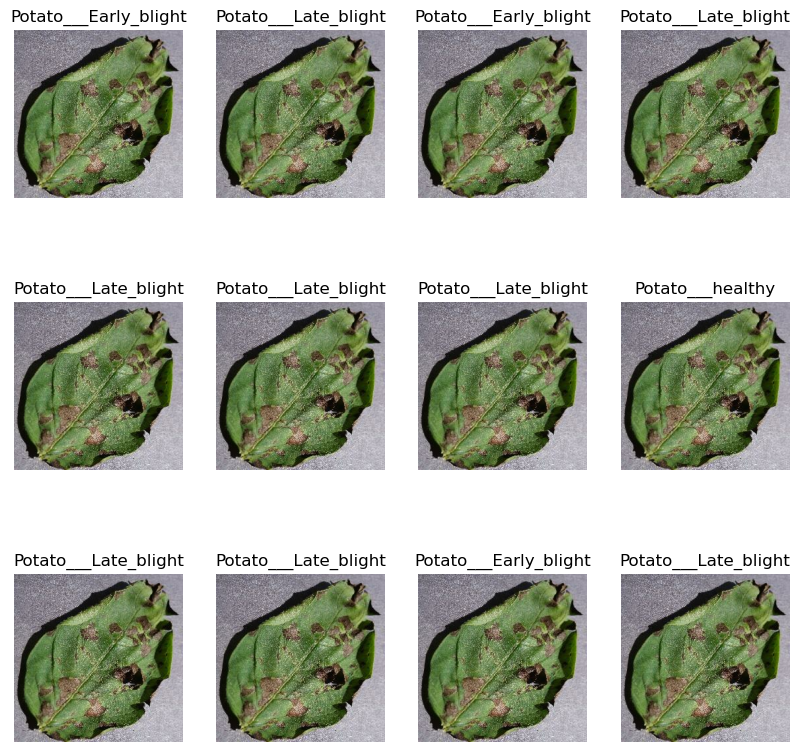

In [41]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8") )
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

### **Function to split dataset**

In [8]:
    def get_dataset_partitions(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
        ds_size=len(ds)
    
        if shuffle:
            ds=ds.shuffle(shuffle_size,seed=12)
            
        train_size=int(train_split*ds_size)
        val_size=int(val_split*ds_size)
    
        train_ds=ds.take(train_size)
        remaining_ds=ds.skip(train_size)
        val_ds=remaining_ds.take(val_size)
        test_ds=remaining_ds.skip(val_size)
        
        return train_ds,val_ds,test_ds

In [9]:
train_ds,val_ds,test_ds=get_dataset_partitions(dataset)

In [10]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### **Building the Model**

#### Creating a layer for resizing and normalization

In [11]:
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Resizes the image to the specified size
    layers.Rescaling(1.0 / 255)  # Normalizes pixel values to the range [0, 1]
])


#### Data Augmentation

In [12]:
data_augmentation= tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Randomly flips the image horizontally and vertically
    layers.RandomRotation(0.7)  # Randomly rotates the image by a factor of 0.7 (within the range of -0.7 to 0.7 radians)
])

#### Model Architecture

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # 3 for RGB images
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),  # Fixed: input_shape
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


C:\Users\eisas\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

#### Model Compiling

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.4439 - loss: 0.9486 - val_accuracy: 0.7083 - val_loss: 0.8519
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.6393 - loss: 0.8009 - val_accuracy: 0.7344 - val_loss: 0.6636
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.7683 - loss: 0.5419 - val_accuracy: 0.8281 - val_loss: 0.3742
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8509 - loss: 0.3715 - val_accuracy: 0.9167 - val_loss: 0.2702
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 971ms/step - accuracy: 0.9047 - loss: 0.2491 - val_accuracy: 0.9115 - val_loss: 0.1843
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 51s 939ms/step - accuracy: 0.8979 - loss: 0.2525 - val_accuracy: 0.9688 - val_loss: 0.0908
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 51s 936ms/step - accuracy: 0.9314 - loss: 0.1724 - val_accuracy: 0.9271 - val_loss: 0.1951
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9620 - loss: 0.1027 - val_accuracy: 0.9583 - 

In [30]:
scores=model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 555ms/step - accuracy: 0.9954 - loss: 0.0138


In [33]:
scores

[0.020104512572288513, 0.9921875]

In [31]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

#### **Plotting the accuracy and loss curves**

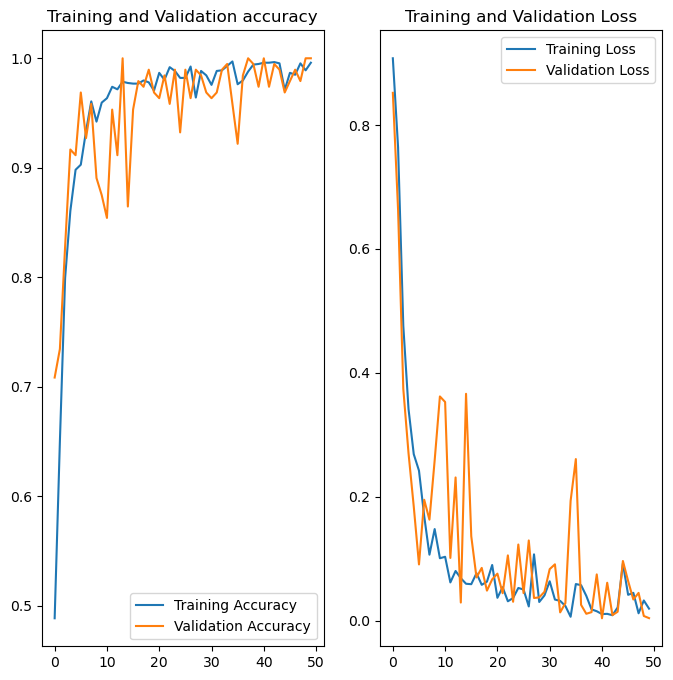

In [32]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Run prediction on a sample**

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
predicted label: Potato___Late_blight


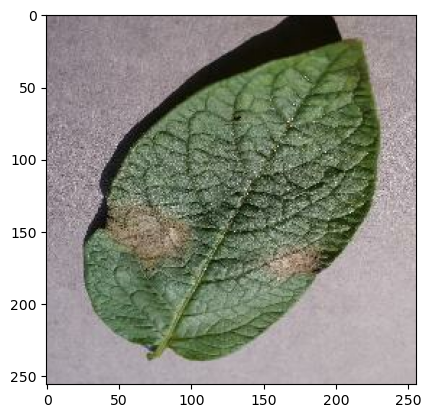

In [46]:

import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [47]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


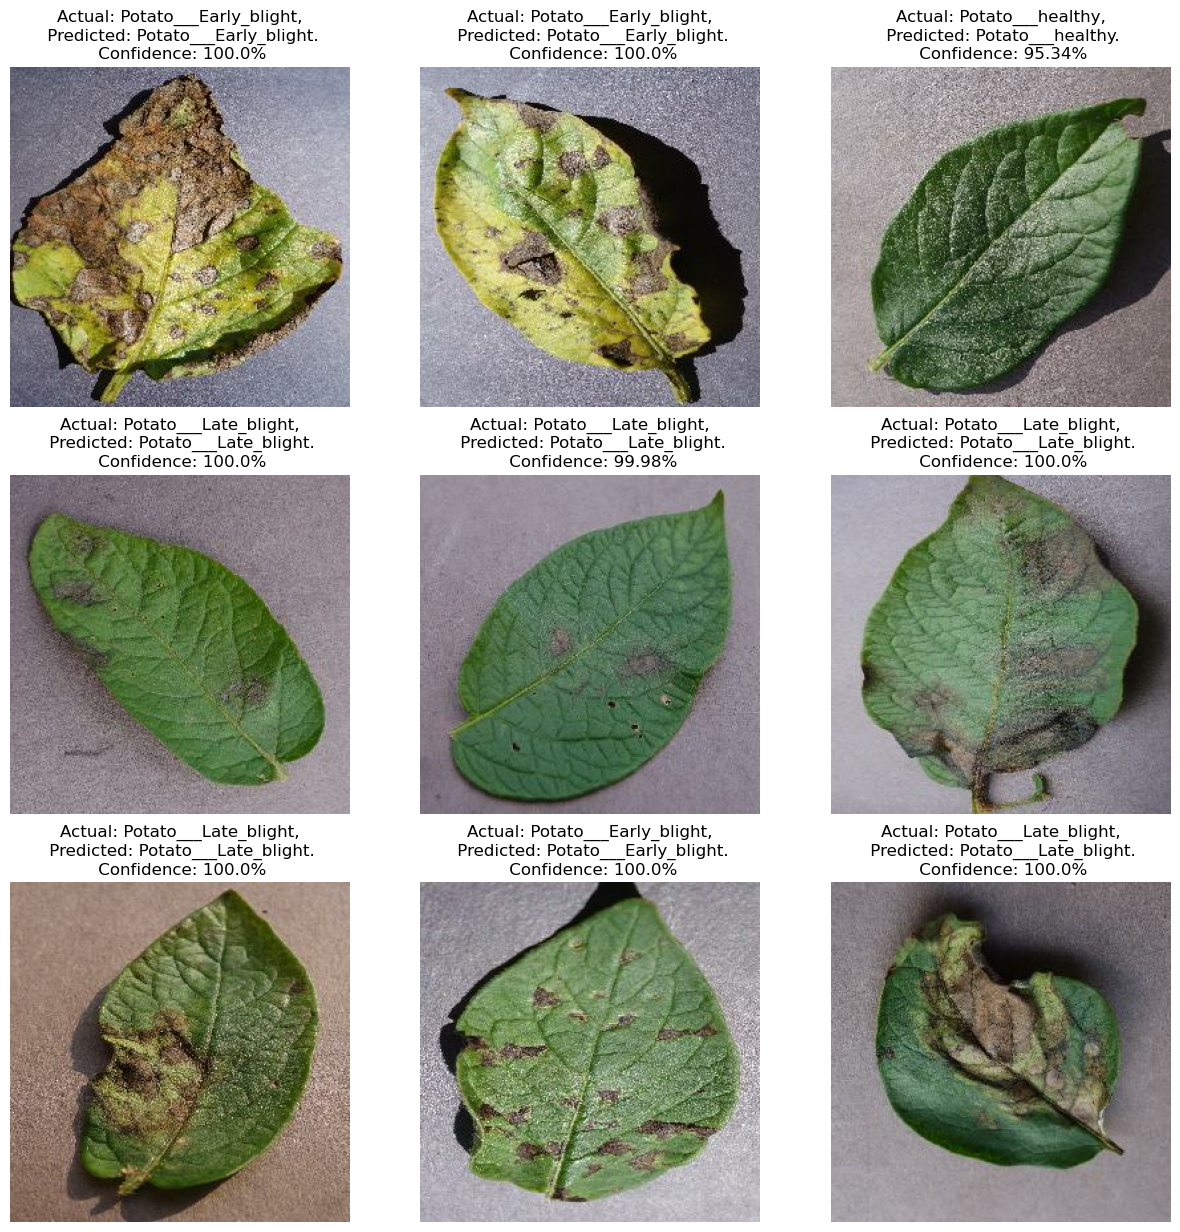

In [48]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### **Saving the model**

In [69]:
import os
import tensorflow as tf
current_directory = os.getcwd()

folder_name = "models"
folder_path = os.path.join(current_directory, folder_name)

model_version = max([int(i) for i in os.listdir(folder_path) if i.isdigit()] + [0]) + 1

model_save_path = os.path.join(folder_path, f"{model_version}.keras")
model.save(model_save_path)

print(f"Model saved at: {model_save_path}")


Model saved at: C:\Users\eisas\projects\Potato_Blight_Deep_learning\models\1.keras
